# Fashion MNIST Classification Project

This notebook explores classification of fashion items using the Fashion MNIST dataset.

### Level 0: Data Loading and Preprocessing

##### Import necessary libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

We have been given two files one of type idx and the other of type csv so we can load any one of them

##### Option 1: Load from CSV


In [100]:
def load_from_csv():
    fashion_df = pd.read_csv('dataset/data.csv')
    return fashion_df

##### Option 2: Load from IDX files directly

In [ ]:
def load_from_idx_files(images_path='dataset/images-idx3-ubyte', labels_path='dataset/labels-idx1-ubyte'):

    def read_idx(filename):
        with open(filename, 'rb') as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4))
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
    import struct

    images = read_idx(images_path)
    labels = read_idx(labels_path)
    pixel_columns = [f'pixel{i+1}' for i in range(28*28)]
    fashion_df = pd.DataFrame(images.reshape(images.shape[0], -1), columns=pixel_columns)
    fashion_df.insert(0, 'label', labels)
    
    return fashion_df


Choose the appropriate loading method (Here I choose IDX)

In [102]:
# fashion_df = load_from_csv()
fashion_df = load_from_idx_files()

Check the dataset shape

In [103]:
print(f"Dataset shape: {fashion_df.shape}")
print("\nFirst few rows of the dataset:")
fashion_df.head()

Dataset shape: (60000, 785)

First few rows of the dataset:


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Define a function to display images with their labels

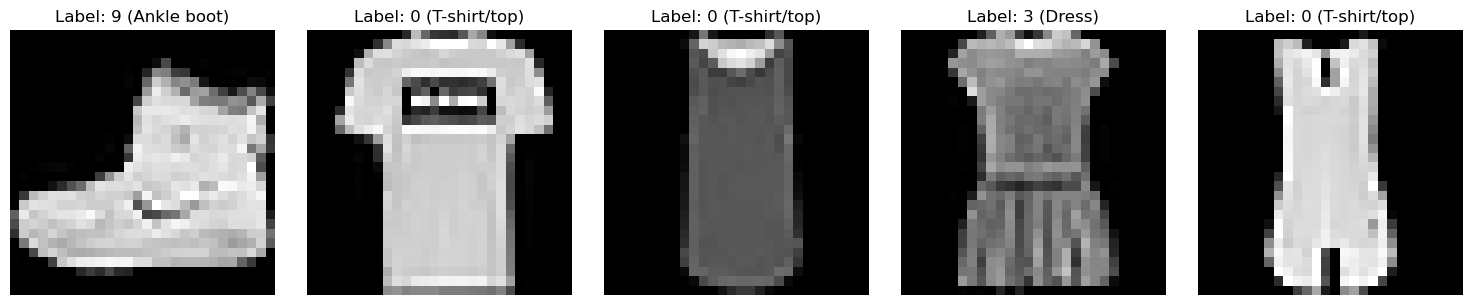

In [104]:
def display_images(dataframe, num_images=5):
    label_mapping = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }
    
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = dataframe.iloc[i, 1:].values.reshape(28, 28)
        plt.imshow(img, cmap='gray')
        label = dataframe.iloc[i, 0]
        plt.title(f"Label: {label} ({label_mapping[label]})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(fashion_df)

Verify grayscale format by checking a single image

In [105]:
single_image = fashion_df.iloc[0, 1:].values
print(f"Min pixel value: {single_image.min()}")
print(f"Max pixel value: {single_image.max()}")
print(f"Shape of a single image: {single_image.reshape(28, 28).shape}")

Min pixel value: 0
Max pixel value: 255
Shape of a single image: (28, 28)


Display a single image with a color bar to show pixel values

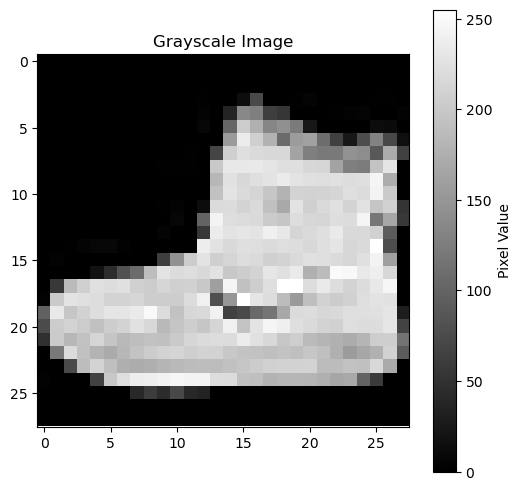

In [106]:
plt.figure(figsize=(6, 6))
plt.imshow(single_image.reshape(28, 28), cmap='gray')
plt.colorbar(label='Pixel Value')
plt.title("Grayscale Image")
plt.show()

### Level 1: Exploratory Data Analysis

Basic summary statistics of pixel values

In [107]:
pixel_stats = fashion_df.iloc[:, 1:].describe()
print(pixel_stats)

             pixel1        pixel2        pixel3        pixel4        pixel5  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000800      0.005783      0.030083      0.103800      0.249683   
std        0.092554      0.249033      0.767868      2.512017      4.331376   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     36.000000    119.000000    164.000000    224.000000   

             pixel6        pixel7        pixel8        pixel9       pixel10  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.414717      0.821667      2.224733      5.698667     14.434650   
std        5.827394      8.309935     14.201820    

Check for missing values

In [108]:
missing_values = fashion_df.isnull().sum().sum()
print(f"\nTotal missing values in the dataset: {missing_values}")


Total missing values in the dataset: 0


Distribution of labels (clothing categories)

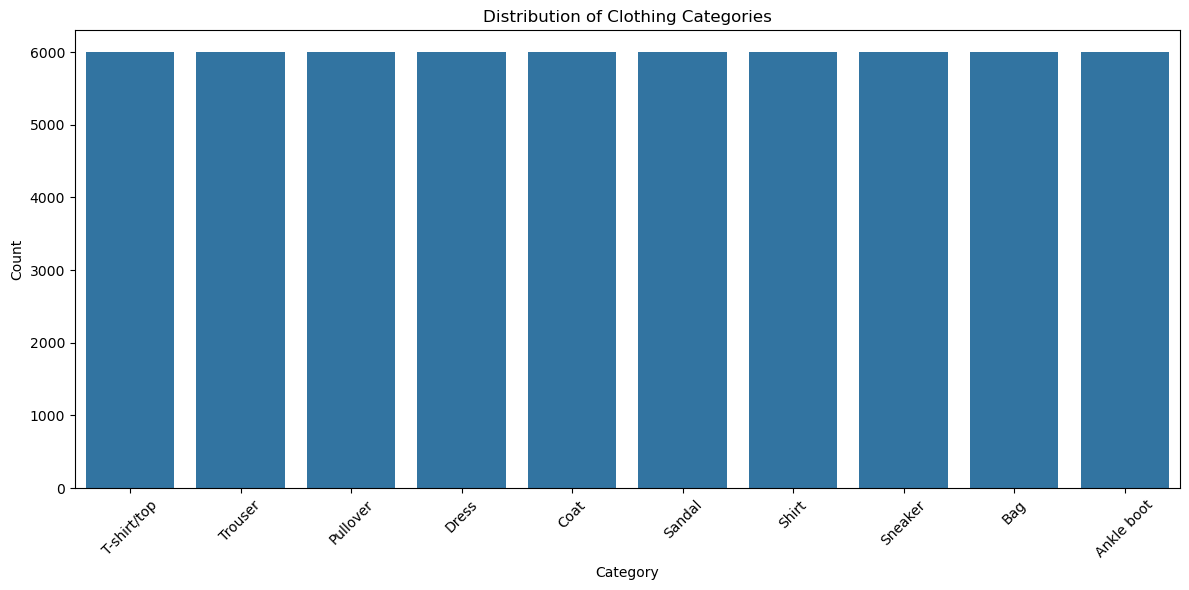

In [109]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=fashion_df.iloc[:, 0])
plt.title('Distribution of Clothing Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(range(10), [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
], rotation=45)
plt.tight_layout()
plt.show()

Display one example from each category

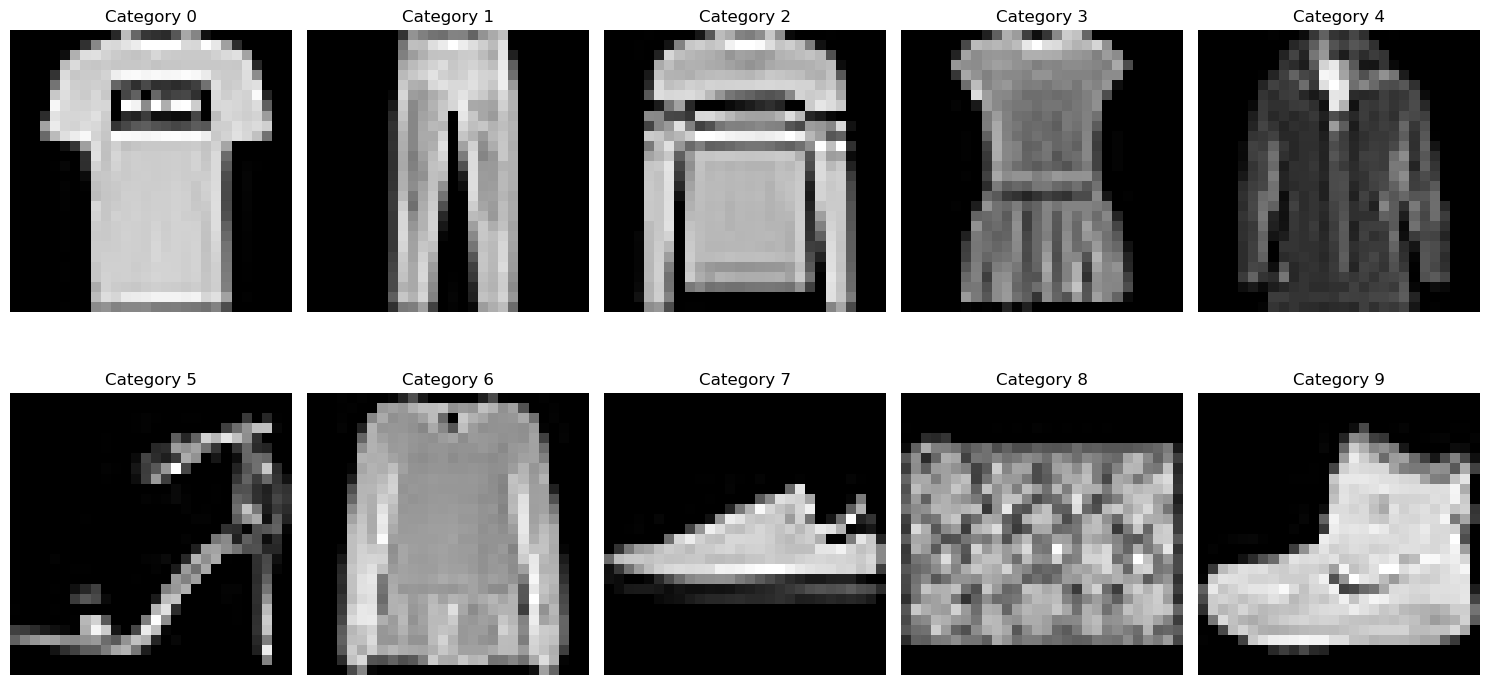

In [110]:
plt.figure(figsize=(15, 8))
for i in range(10):
    idx = fashion_df[fashion_df.iloc[:, 0] == i].index[0]
    plt.subplot(2, 5, i+1)
    img = fashion_df.iloc[idx, 1:].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Category {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Pixel intensity distribution

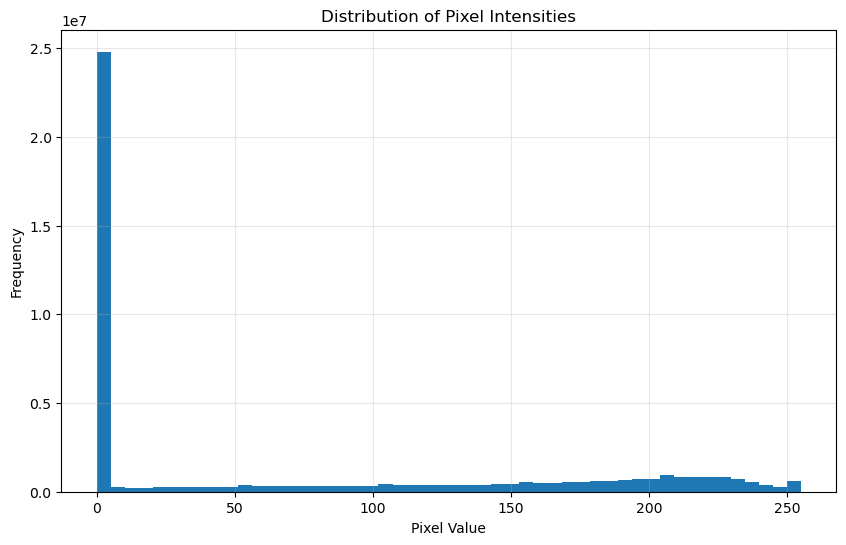

In [111]:
plt.figure(figsize=(10, 6))
plt.hist(fashion_df.iloc[:, 1:].values.flatten(), bins=50)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

Average image per class to see patterns

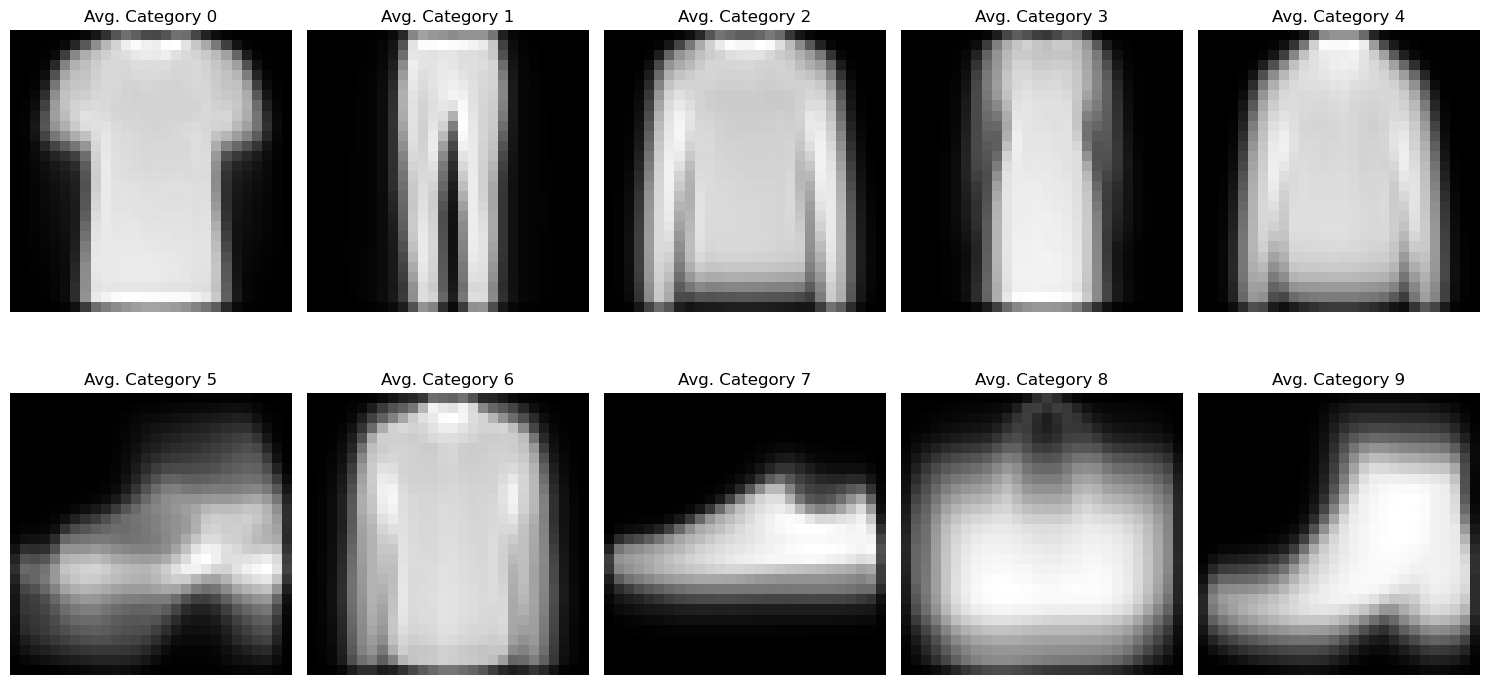

In [112]:
avg_images = []
for i in range(10):
    class_images = fashion_df[fashion_df.iloc[:, 0] == i].iloc[:, 1:].values
    avg_image = np.mean(class_images, axis=0).reshape(28, 28)
    avg_images.append(avg_image)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(avg_images[i], cmap='gray')
    plt.title(f"Avg. Category {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Level 2: Basic Classification Model (Logistic Regression)

Prepare the data

In [113]:
X = fashion_df.iloc[:, 1:].values  
y = fashion_df.iloc[:, 0].values   

Split the data into training and testing sets (80% train, 20% test)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (48000, 784)
Testing set shape: (12000, 784)


Normalize the data using StandardScaler 

In [115]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train the logistic regression model

In [116]:
print("\nTraining logistic regression model...")
lr_model = LogisticRegression(
    max_iter=1000,          
    solver='saga',    # Using 'saga' solver for faster convergence with multinomial classification      
    multi_class='multinomial',  
    n_jobs=-1,              
    random_state=42       
)

lr_model.fit(X_train_scaled, y_train)
print("Training complete!")


Training logistic regression model...
Training complete!


c:\Users\sidha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Evaluate the Model

In [117]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression Accuracy: {accuracy:.4f}")


Logistic Regression Accuracy: 0.8491


Confusion matrix

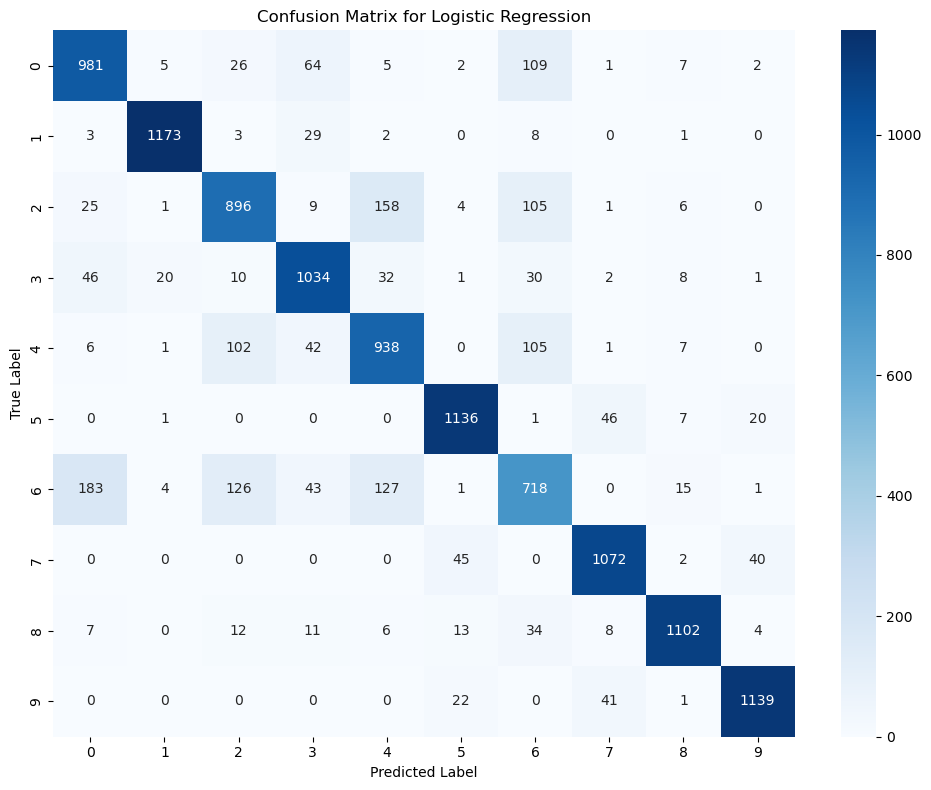

In [118]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(10),
           yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.tight_layout()
plt.show()

Classification report

In [119]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1202
           1       0.97      0.96      0.97      1219
           2       0.76      0.74      0.75      1205
           3       0.84      0.87      0.86      1184
           4       0.74      0.78      0.76      1202
           5       0.93      0.94      0.93      1211
           6       0.65      0.59      0.62      1218
           7       0.91      0.92      0.92      1159
           8       0.95      0.92      0.94      1197
           9       0.94      0.95      0.95      1203

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



##### Explainable AI: Feature Importance Visualization
For logistic regression, coefficients can indicate feature importance

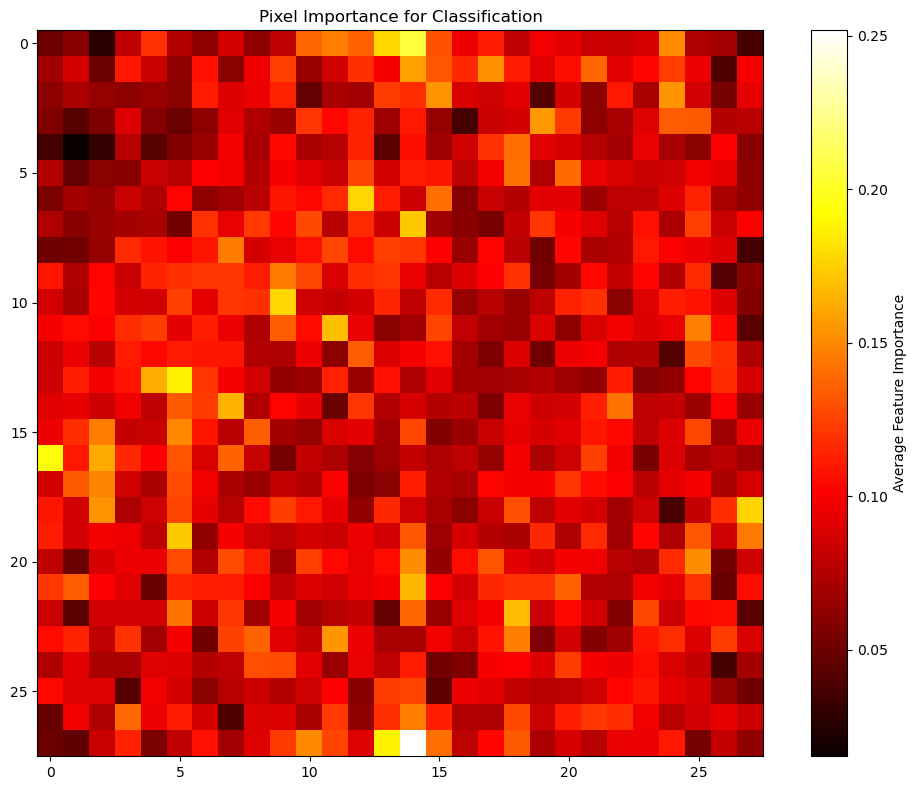

In [120]:
feature_importance = np.abs(lr_model.coef_)
avg_importance = np.mean(feature_importance, axis=0)
importance_img = avg_importance.reshape(28, 28)

plt.figure(figsize=(10, 8))
plt.imshow(importance_img, cmap='hot')
plt.colorbar(label='Average Feature Importance')
plt.title('Pixel Importance for Classification')
plt.tight_layout()
plt.show()

Display most important pixels overlaid on sample images

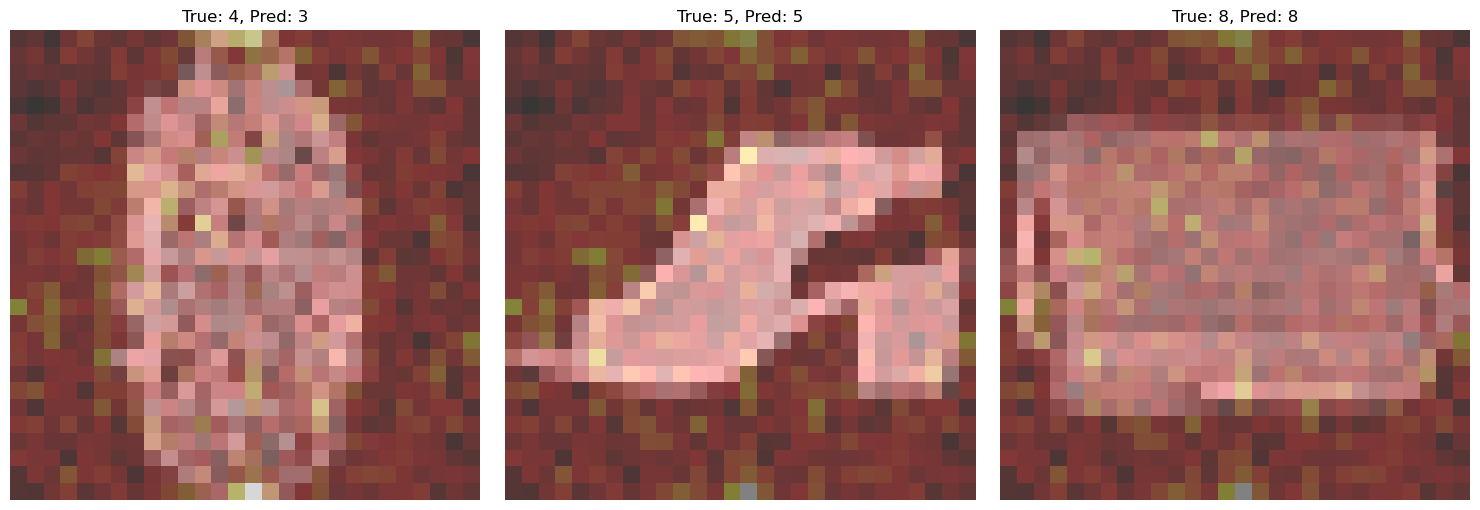

In [121]:
num_samples = 3
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    idx = np.random.randint(len(X_test))
    img = X_test[idx].reshape(28, 28)
    plt.imshow(img, cmap='gray', alpha=0.7)
    plt.imshow(importance_img, cmap='hot', alpha=0.3)
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Level 3: Neural Network Implementation

Prepare the data for neural networks

In [122]:
X = fashion_df.iloc[:, 1:].values / 255.0 
y = fashion_df.iloc[:, 0].values

Split into training, validation, and testing sets

In [123]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (42000, 784)
Validation set: (9000, 784)
Testing set: (9000, 784)


Reshape the data for CNN (28X28) and Define Label Mapping

In [124]:
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_val_reshaped = X_val.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

Defining CNN model

In [125]:
from tensorflow import keras
from tensorflow.keras import layers  


def create_cnn_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Prevent overfitting
        
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Creating a simple MLP model for comparison

In [126]:
def create_mlp_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),  
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Create and train the CNN model

In [127]:
cnn_model = create_cnn_model()
print("CNN Model Summary:")
cnn_model.summary()

CNN Model Summary:


c:\Users\sidha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

Use early stopping to prevent overfitting

In [128]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Train the CNN model

In [129]:
cnn_history = cnn_model.fit(
    X_train_reshaped,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6385 - loss: 0.9973 - val_accuracy: 0.8452 - val_loss: 0.4189
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8302 - loss: 0.4589 - val_accuracy: 0.8706 - val_loss: 0.3489
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8643 - loss: 0.3804 - val_accuracy: 0.8840 - val_loss: 0.3074
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8778 - loss: 0.3388 - val_accuracy: 0.8871 - val_loss: 0.3094
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8886 - loss: 0.3088 - val_accuracy: 0.8892 - val_loss: 0.2987
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8940 - loss: 0.2899 - val_accuracy: 0.8978 - val_loss: 0.2808
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9020 - loss: 0.2685 - val_accuracy: 0.9037 - val_loss: 0.2644
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9105 - loss: 0.2420 - val_accuracy: 0.

Create and train the MLP model

In [130]:
mlp_model = create_mlp_model()
print("MLP Model Summary:")
mlp_model.summary()

MLP Model Summary:


c:\Users\sidha\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Train the MLP model

In [131]:
mlp_history = mlp_model.fit(
    X_train_reshaped,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping]
)


Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6772 - loss: 0.9162 - val_accuracy: 0.8328 - val_loss: 0.4516
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8291 - loss: 0.4776 - val_accuracy: 0.8582 - val_loss: 0.3952
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8487 - loss: 0.4141 - val_accuracy: 0.8597 - val_loss: 0.3666
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8606 - loss: 0.3841 - val_accuracy: 0.8762 - val_loss: 0.3382
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8698 - loss: 0.3594 - val_accuracy: 0.8770 - val_loss: 0.3431
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8709 - loss: 0.3462 - val_accuracy: 0.8791 - val_loss: 0.3357
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8742 - loss: 0.3396 - val_accuracy: 0.8763 - val_loss: 0.3320
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8764 - loss: 0.3335 - val_accuracy: 0.

Plot training history to compare models

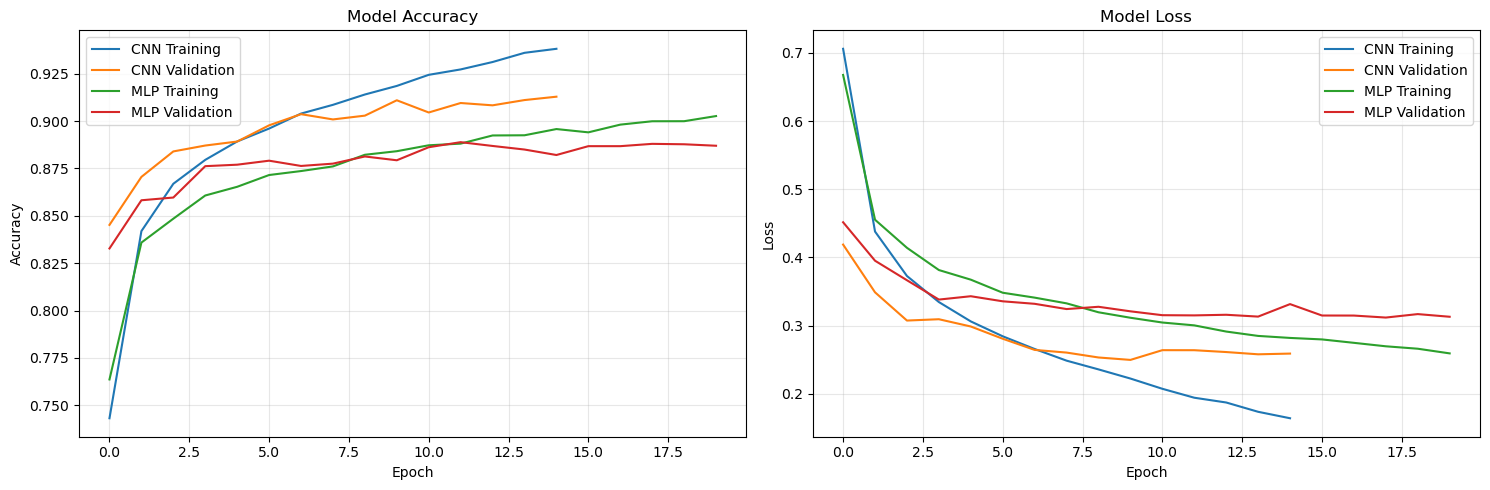

In [132]:
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation')
plt.plot(mlp_history.history['accuracy'], label='MLP Training')
plt.plot(mlp_history.history['val_accuracy'], label='MLP Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation')
plt.plot(mlp_history.history['loss'], label='MLP Training')
plt.plot(mlp_history.history['val_loss'], label='MLP Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Evaluate models on test set

In [133]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test_reshaped, y_test)
mlp_test_loss, mlp_test_acc = mlp_model.evaluate(X_test_reshaped, y_test)

print(f"\nCNN Test Accuracy: {cnn_test_acc:.4f}")
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")

# Choosing best Model based on accurracy
best_model = cnn_model if cnn_test_acc > mlp_test_acc else mlp_model
best_model_name = "CNN" if cnn_test_acc > mlp_test_acc else "MLP"
print(f"\nBest model: {best_model_name} with accuracy {max(cnn_test_acc, mlp_test_acc):.4f}")

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2432
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8887 - loss: 0.3145

CNN Test Accuracy: 0.9128
MLP Test Accuracy: 0.8883

Best model: CNN with accuracy 0.9128


Generate predictions with the best model

In [134]:
y_pred = best_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Confusion matrix

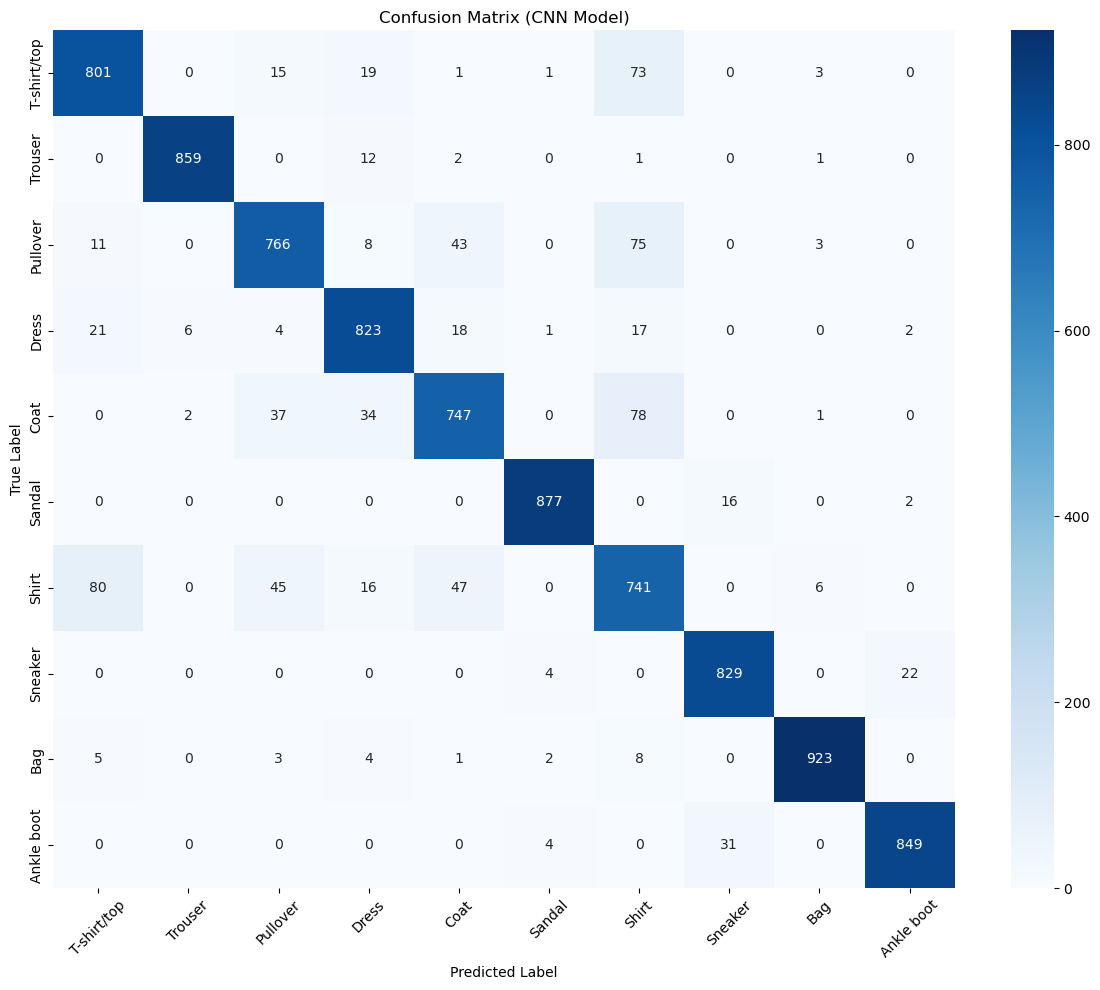

In [135]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=[label_mapping[i] for i in range(10)],
           yticklabels=[label_mapping[i] for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix ({best_model_name} Model)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Classification report 

In [136]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[label_mapping[i] for i in range(10)]))


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87       913
     Trouser       0.99      0.98      0.99       875
    Pullover       0.88      0.85      0.86       906
       Dress       0.90      0.92      0.91       892
        Coat       0.87      0.83      0.85       899
      Sandal       0.99      0.98      0.98       895
       Shirt       0.75      0.79      0.77       935
     Sneaker       0.95      0.97      0.96       855
         Bag       0.99      0.98      0.98       946
  Ankle boot       0.97      0.96      0.97       884

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000



Display some correctly and incorrectly classified images

In [137]:
def display_predictions(X, y_true, y_pred, num_images=5):
    correct_indices = np.where(y_true == y_pred)[0]
    incorrect_indices = np.where(y_true != y_pred)[0]

    plt.figure(figsize=(15, 5))
    plt.suptitle("Correctly Classified Images", fontsize=16)
    for i in range(min(num_images, len(correct_indices))):
        plt.subplot(1, num_images, i+1)
        idx = correct_indices[i]
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {label_mapping[y_true[idx]]}\nPred: {label_mapping[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.suptitle("Incorrectly Classified Images", fontsize=16)
    for i in range(min(num_images, len(incorrect_indices))):
        plt.subplot(1, num_images, i+1)
        idx = incorrect_indices[i]
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {label_mapping[y_true[idx]]}\nPred: {label_mapping[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Display some predictions

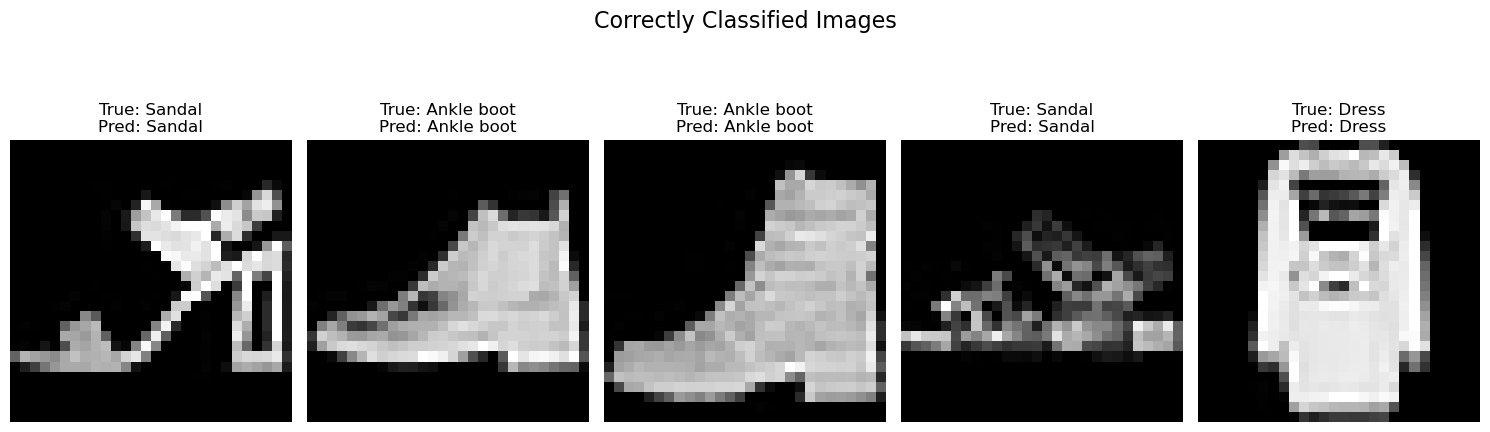

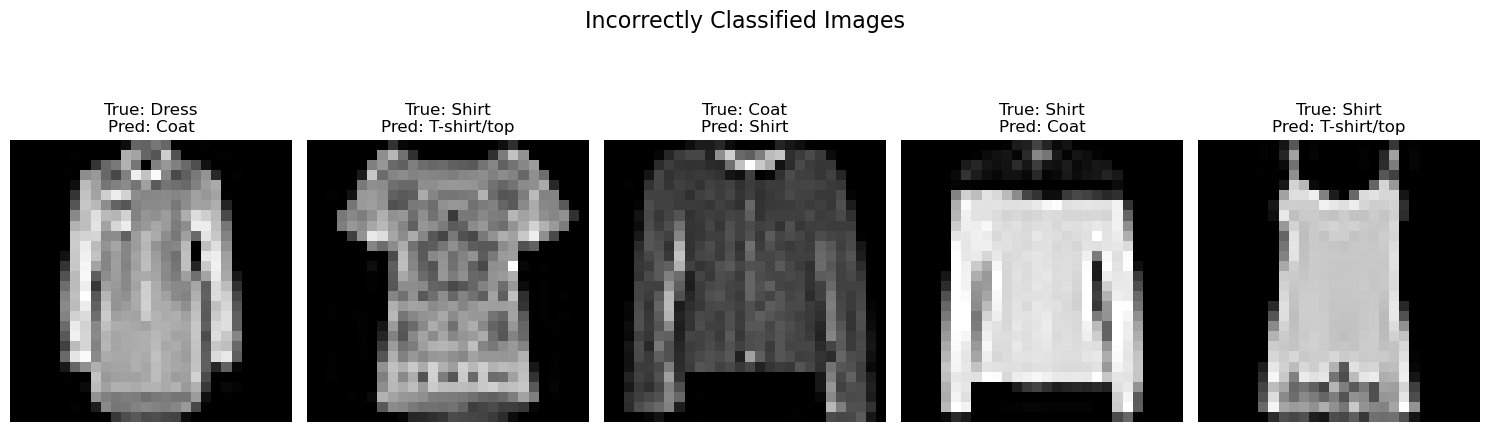

In [138]:
display_predictions(X_test_reshaped, y_test, y_pred_classes)

Save the best model for future use

In [139]:
best_model.save(f'fashion_mnist_{best_model_name}_model.h5')
print(f"\nModel saved as fashion_mnist_{best_model_name}_model.h5")


Model saved as fashion_mnist_CNN_model.h5


BONUS : Create a function for making predictions on new data

In [140]:
def predict_fashion_item(model, image):
    """
    Function to preprocess an image and predict its class.
    
    Parameters:
    model: The trained Keras model
    image: A 28x28 image array
    
    Returns:
    predicted_class: The predicted class index
    confidence: The confidence score
    """
    # Checking shape 
    if image.shape != (28, 28, 1):
        image = image.reshape(28, 28, 1)
    
    # Normalize 
    image = image / 255.0
    
    # Reshape for model input
    image_batch = np.expand_dims(image, axis=0)
    
    # Make prediction
    predictions = model.predict(image_batch)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    return predicted_class, confidence